# Deep Learning & Art: Neural Style Transfer

**In this exercise, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize **a cost function** to get pixel values!

In [78]:
from google.colab import drive

# This will prompt for authorization.

import os
os.chdir('/content/drive/My Drive/Option_AI_2nd/ML/TP5-todo')
!pwd


/content/drive/My Drive/Option_AI_2nd/ML/TP5-todo


In [15]:
!wget https://www.dropbox.com/s/0k96ahmyj1k4qbu/imagenet-vgg-verydeep-19.mat?dl=0 \
    -O /content/drive/My\ Drive/Option_AI_2nd/ML/TP5-todo/pretrained-model/imagenet-vgg-verydeep-19.mat

--2019-02-21 09:32:14--  https://www.dropbox.com/s/0k96ahmyj1k4qbu/imagenet-vgg-verydeep-19.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0k96ahmyj1k4qbu/imagenet-vgg-verydeep-19.mat [following]
--2019-02-21 09:32:15--  https://www.dropbox.com/s/raw/0k96ahmyj1k4qbu/imagenet-vgg-verydeep-19.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccc86b6119ed5a62170dc958a3b.dl.dropboxusercontent.com/cd/0/inline/AbsKGuX3kHkkGlWgIE9fLVxqy_Ew4pvUlt1593ZtxzMlawu2mPMMjUes-NVSsEkpYZKgG54EOqEaT2HJMEu5Q2scvUHFkm1KUvRZCAPZ3ZLFCyxvhhmhltOk7ScjulF2Uow/file# [following]
--2019-02-21 09:32:15--  https://uccc86b6119ed5a62170dc958a3b.dl.dropboxusercontent.com/cd/0/inline/AbsKGuX3kHkkGlWgIE9fLVxqy_Ew4pvUlt1593ZtxzMlawu2mPMMjUes-N

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
from IPython.display import Image

%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) merges two images, a "content" image (C) and a "style" image (S), to create a "generated" image (G).

You are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).

In [0]:
Image("images/louvre_generated.png")

## 2 - Transfer Learning

NST uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network (VGG-19). This model has been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model (please download the model before).

In [69]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

To run an image through this network, you just have to feed the image to the model (in TensorFlow, use [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function). 
```python
model["input"].assign(image)
```
After this, if **you want to access the activations of a particular layee**, say layer `4_2` (`conv4_2`) when the network is run on this image:  
```python
sess.run(model["conv4_2"])
```

## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

Let's see a picture of the Louvre.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


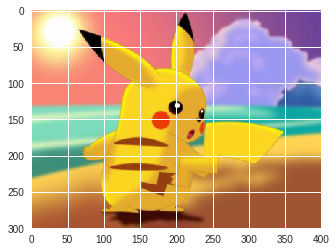

In [82]:
content_image = scipy.misc.imread("images/pikachu.jpg")
imshow(content_image)

** 3.1.1 - How do you ensure the generated image G matches the content of the image C?**

The earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes. 

The generated image G would have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. You'll get the most visually pleasing results if you choose a layer in the middle of the network. <font color='red'>(**After you have finished this exercise, please come back and experiment with using different layers, to see how the results vary.**)</font>

Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G (let $a^{(G)}$ be the corresponding hidden layer activation). The content cost function is defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen. **Note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations**. In order to compute the cost $J_{content}(C,G)$, it might be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

**Exercise:** Compute the "content cost" using TensorFlow. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from a_G: 
    - Use: `X.get_shape().as_list()`
2. Unroll a_C and a_G as explained in the picture above
    - [Hint1](https://www.tensorflow.org/versions/r1.3/api_docs/python/tf/transpose) and [Hint2](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/reshape).
3. Compute the content cost:
    - [Hint3](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [Hint4](https://www.tensorflow.org/api_docs/python/tf/square) and [Hint5](https://www.tensorflow.org/api_docs/python/tf/subtract).

In [0]:
Image("images/NST_LOSS.png")

In [0]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    a, n_H, n_W, n_C= a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C=tf.reshape(tf.transpose(a_C,[0,3,1,2]),[a,n_C,n_H*n_W])
    a_G=tf.reshape(tf.transpose(a_G,[0,3,1,2]),[a,n_C,n_H*n_W])
    
    # transpose
    #It is actually mentioned as one of the two hints provided is
    # tf.transpose, apart from that if you look in the cost computation
    # of generated image also the dimension of the actual matrix given
    # is n_H * n_W * n_C, but for style cost we have to make the
    # dimensions as n_C * (n_H *n_W), so transpose then reshape.
    # style loss
    
    # compute the cost with tensorflow (≈1 line)
    J_content=tf.multiply(1/(4*n_H*n_W*n_C),tf.math.reduce_sum(tf.math.square(tf.math.subtract(a_C,a_G))))
    ### END CODE HERE ###
    
    return J_content

In [22]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


**Expected Output**:

<table>
    <tr>
        <td>
            **J_content**
        </td>
        <td>
           6.76559
        </td>
    </tr>

</table>

<font color='blue'>
**What you should remember**:
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


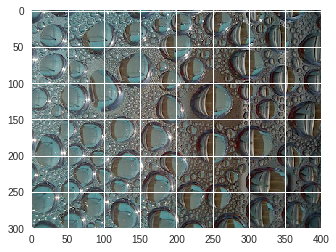

In [94]:
style_image = scipy.misc.imread("images/drop-of-water.jpg")
imshow(style_image)

Lets see how you can now define a "style" const function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

The **style matrix** is also called a "**Gram matrix**". In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, $G_{ij}$ would be large. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

In [0]:
Image("images/NST_GM.png")


The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. **The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. **

The Style matrix $G$ measures the style of an image. 

**Exercise**:
Using TensorFlow, implement a function that computes the Gram matrix of a matrix A ($G_A = AA^T$). [Hint 1](https://www.tensorflow.org/api_docs/python/tf/matmul) and [Hint 2](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [0]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [26]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305  -4.4291224 -2.096682 ]
 [-4.4291224 19.465837  19.563871 ]
 [-2.096682  19.563871  20.686462 ]]


**Expected Output**:

<table>
    <tr>
        <td>
            **GA**
        </td>
        <td>
           [[  6.42230511  -4.42912197  -2.09668207] <br>
 [ -4.42912197  19.46583748  19.56387138] <br>
 [ -2.09668207  19.56387138  20.6864624 ]]
        </td>
    </tr>

</table>

### 3.2.2 - Style cost

Your goal now is to **minimize the distance between the Gram matrix of the style image S $G^{(S)}$ and that of the generated image G $G^{(G)}$**. 

Consider that we are using only a single hidden layer $a^{[l]}$, and the corresponding style: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$


**Exercise**: Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
    - Use: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.
    - You may find [Hint1](https://www.tensorflow.org/versions/r1.3/api_docs/python/tf/transpose) and [Hint2](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/reshape) useful.
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost:
    - You may find [Hint3](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [Hint4](https://www.tensorflow.org/api_docs/python/tf/square) and [Hint5](https://www.tensorflow.org/api_docs/python/tf/subtract) useful.

In [0]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    a, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_G=tf.reshape(tf.transpose(a_G,[0,3,1,2]),[n_C,n_H*n_W])
    a_S=tf.reshape(tf.transpose(a_S,[0,3,1,2]),[n_C,n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    a_G_Gram = gram_matrix(a_G)
    a_S_Gram = gram_matrix(a_S)

    # Computing the loss (≈1 line)
    J_style_layer = tf.multiply(1/((2*n_C*n_H*n_W)**2),tf.math.reduce_sum(tf.math.reduce_sum(tf.math.square(tf.math.subtract(a_S_Gram,a_G_Gram)))))
    
    ### END CODE HERE ###
    
    return J_style_layer

In [28]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190279


**Expected Output**:

<table>
    <tr>
        <td>
            **J_style_layer**
        </td>
        <td>
           9.19028
        </td>
    </tr>

</table>

### 3.2.3 Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. **After completing this exercise, please come back and experiment with different weights to see how it changes the generated image $G$**. But for now, this is a pretty reasonable default: 

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

**Exercise:** Implement the style cost function.


In [0]:
# GRADED FUNCTION: style_cost
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        ### START CODE HERE ### (1 line)
        J_style= J_style + J_style_layer*coeff
        ### END CODE HERE ### 

    return J_style

**Note**: In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.

### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [0]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J=alpha*J_content + beta*J
    ### END CODE HERE ###
    
    return J

In [32]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


**Expected Output**:

<table>
    <tr>
        <td>
            **J**
        </td>
        <td>
           35.34667875478276
        </td>
    </tr>

</table>

<font color='blue'>
**What you should remember**:
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style

## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='purple'>

- 1. Create an Interactive Session

- 2. Load the content image and the style one.

- 3. Randomly initialize the image to be generated 

- 4. Load the VGG19 model

- 5. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate

- 6. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>

You've implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  This allows you to run variables without constantly needing to refer to the session object, which simplifies the code.  

Lets start the interactive session.

In [102]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [103]:
###Let's load, reshape, and normalize our "content" image (the Louvre museum picture):
content_image = scipy.misc.imread("images/pikachu.jpg")
content_image = reshape_and_normalize_image(content_image)

###Let's load, reshape and normalize our "style" image (Claude Monet's painting):
style_image = scipy.misc.imread("images/drop-of-water.jpg")
style_image = reshape_and_normalize_image(style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


Now, we initialize the generated image as a noisy image created from the content_image. (Feel free to look in `nst_utils.py` to see the details of `generate_noise_image(...)`.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


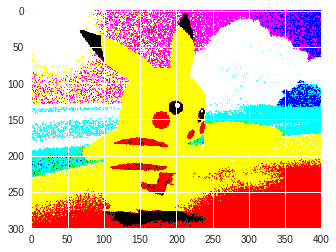

In [104]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Let's load the VGG model.

In [0]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [0]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
### START CODE HERE ### (≈1 line)
J_content = compute_content_cost(a_C, a_G)
### END CODE HERE ###


**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [0]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
### START CODE HERE ### (≈1 line)
J_style = compute_style_cost(model, STYLE_LAYERS)
### END CODE HERE ###

**Exercise**: Now that you have J_content and J_style, compute the total cost J by calling `total_cost()`. Use `alpha = 10` and `beta = 40`.

In [0]:
# define the total cost
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

In [0]:
# define optimizer using Adam optimizer (1 line)
### START CODE HERE ### (1 line)
optimizer = tf.train.AdamOptimizer(learning_rate = 2)
### END CODE HERE ###

# define train_step (1 line)
train_step = optimizer.minimize(J)

**Exercise**: Implement the model_nn() function which initializes the variables of the tensorflow graph, assigns the input image (initial generated image) as the input of the VGG model and runs the train_step for a large number of steps.

In [0]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        _ = sess.run([train_step]) 
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [111]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 2183389200.0
content cost = 17277.418
style cost = 54580410.0
Iteration 20 :
total cost = 258807200.0
content cost = 26070.89
style cost = 6463662.5
Iteration 40 :
total cost = 107938880.0
content cost = 28702.23
style cost = 2691296.5
Iteration 60 :
total cost = 66324604.0
content cost = 29937.822
style cost = 1650630.6
Iteration 80 :
total cost = 48006508.0
content cost = 30726.277
style cost = 1192481.1
Iteration 100 :
total cost = 37545028.0
content cost = 31297.436
style cost = 930801.3
Iteration 120 :
total cost = 30743430.0
content cost = 31737.281
style cost = 760651.44
Iteration 140 :
total cost = 25956154.0
content cost = 32096.395
style cost = 640879.75
Iteration 160 :
total cost = 22407244.0
content cost = 32397.566
style cost = 552081.7
Iteration 180 :
total cost = 19662928.0
content cost = 32652.309
style cost = 483410.1


array([[[[ 14.782518  , -13.247496  ,  -6.5584173 ],
         [ -6.9196205 ,  -9.261717  ,  -5.1285357 ],
         [ 29.821379  ,  15.1894045 ,  12.099846  ],
         ...,
         [ 37.42591   ,   5.6116943 , -32.257523  ],
         [ 27.043753  ,  22.046608  ,  43.827187  ],
         [ 45.132847  ,  19.916908  ,  36.227577  ]],

        [[ 23.057829  ,   2.949305  ,   0.87694716],
         [-29.457876  , -10.298697  ,  -2.543829  ],
         [ 30.201355  ,  10.244434  ,  32.524414  ],
         ...,
         [-68.175     , -50.1914    , -37.588158  ],
         [ 10.857959  , -27.026602  , -44.25528   ],
         [ 55.13189   ,  12.496271  ,  19.766842  ]],

        [[ 13.473182  ,  -7.525347  ,  -4.5575843 ],
         [  0.98668367,   5.4096003 ,  23.865656  ],
         [ 49.93997   ,  55.69473   ,  37.987274  ],
         ...,
         [  1.8249476 ,  13.15887   ,  -8.85912   ],
         [-61.433594  , -35.709682  , -22.793749  ],
         [-18.792187  , -28.47722   ,  -9.32161   ]],

**Expected Output**:

<table>
    <tr>
        <td>
            **Iteration 0 : **
        </td>
        <td>
           total cost = 5.05035e+09 <br>
           content cost = 7877.67 <br>
           style cost = 1.26257e+08
        </td>
    </tr>

</table>

Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better.

In [0]:
Image("images/louvre_generated.png")

Here are few other examples:

In [0]:
Image("images/perspolis_vangogh.png")
Image("images/pasargad_kashi.png")
Image("images/circle_abstract.png")

## 5 - Test with your own image

Test with your own image, requirement: (WIDTH = 300, HEIGHT = 225))

You can also tune your hyperparameters: 
- Which layers are responsible for representing the style? STYLE_LAYERS
- How many iterations do you want to run the algorithm? num_iterations
- What is the relative weighting between content and style? alpha/beta

## 6 - Conclusion

You have built a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

<font color='blue'>
What you should remember:
- NST uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 


